In [ ]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax

class WaveEquation2D(Problem):
    """Solves the time-dependent 1D viscous Burgers equation
        d^2 u       d^2 u    
        ----- - c^2 ----- = 0
        d t^2       d x^2    

        for (x, t) in [0, 1]^2

        Boundary conditions:
        u(0, t) = 0
        u(1, t) = 0
        u(x, 0) = sin(πx) + 0.5 sin(4πx)
        u_t(x, 0) = 0
    """

    @staticmethod
    def init_params(c=jnp.sqrt(2), sd=0.1):

        static_params = {
            "dims":(1,2),
            "c":c,
            "sd":sd,
            }
        
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh(x/sd) * tanh((1-x)/sd) * t**2 * u  + (sin(pi*x) + 0.5 * sin(4*pi*x))
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx

        # selected = all_params["trainable"]["problem"]["selected"].astype(jnp.int32)
        # attention = all_params["trainable"]["attention"]["alpha"][selected]  # (N,1)
        # current_i = all_params["trainable"]["problem"]["current_i"]

        mse = jnp.mean(phys**2)
        # attention_loss = jnp.mean(
        #     jnp.exp(-current_i*0.001)*mse + (attention*phys)**2
        #     )
        # jax.debug.print("curr_i = {i}, raw MSE = {m1:.6f}, weighted MSE = {m2:.6f}", i=current_i, m1=mse, m2=attention_loss)
        # jax.debug.print("residual max = {a}, attention head = {b}", a=jnp.max(jnp.abs(phys)), b=attention[:5, 0])
        
        return mse, phys
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        c = all_params["static"]["problem"]["c"]
        x, t, sin, cos, pi = x_batch[:,0:1], x_batch[:,1:2], jnp.sin, jnp.cos, jnp.pi
        u = sin(pi*x)*cos(c*pi*t) + 0.5 * sin(4*pi*x)*cos(4*c*pi*t)
        return u

[INFO] 2025-05-13 20:52:26 - <fbpinns.constants.Constants object at 0x7814f8341cd0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (0.0, 5.0)}
network: 

[INFO] 2025-05-13 20:52:26 - Total number of subdomains: 100
[INFO] 2025-05-13 20:52:26 - Total number of trainable parameters:
[INFO] 2025-05-13 20:52:26 - 	attention: 40,000
[INFO] 2025-05-13 20:52:26 - 	problem: 1
[INFO] 2025-05-13 20:52:26 - 	network: 8,700
[INFO] 2025-05-13 20:52:26 - Total number of constraints: 1
[INFO] 2025-05-13 20:52:26 - Computing exact solution..
[INFO] 2025-05-13 20:52:26 - Computing done
[INFO] 2025-05-13 20:52:26 - Getting test data inputs..
[INFO] 2025-05-13 20:52:26 - [i: 0/40000] Updating active inputs..
[INFO] 2025-05-13 20:52:26 - [i: 0/40000] Average number of points/dimension in active subdomains: 56.00
[INFO] 2025-05-13 20:52:26 - [i: 0/40000] Updating active inputs done (0.18 s)
[INFO] 2025-05-13 20:52:26 - [i: 0/40000] Compiling update step..
[INFO] 2025-05-13 20:52:26 - x_batch
[INFO] 2025-05-13 20:52:26 - (40000, 2), float32, JVPTracer
[INFO] 2025-05-13 20:52:26 - x_take
[INFO] 2025-05-13 20:52:26 - (313600, 2), float32, JVPTracer
[INFO] 2025

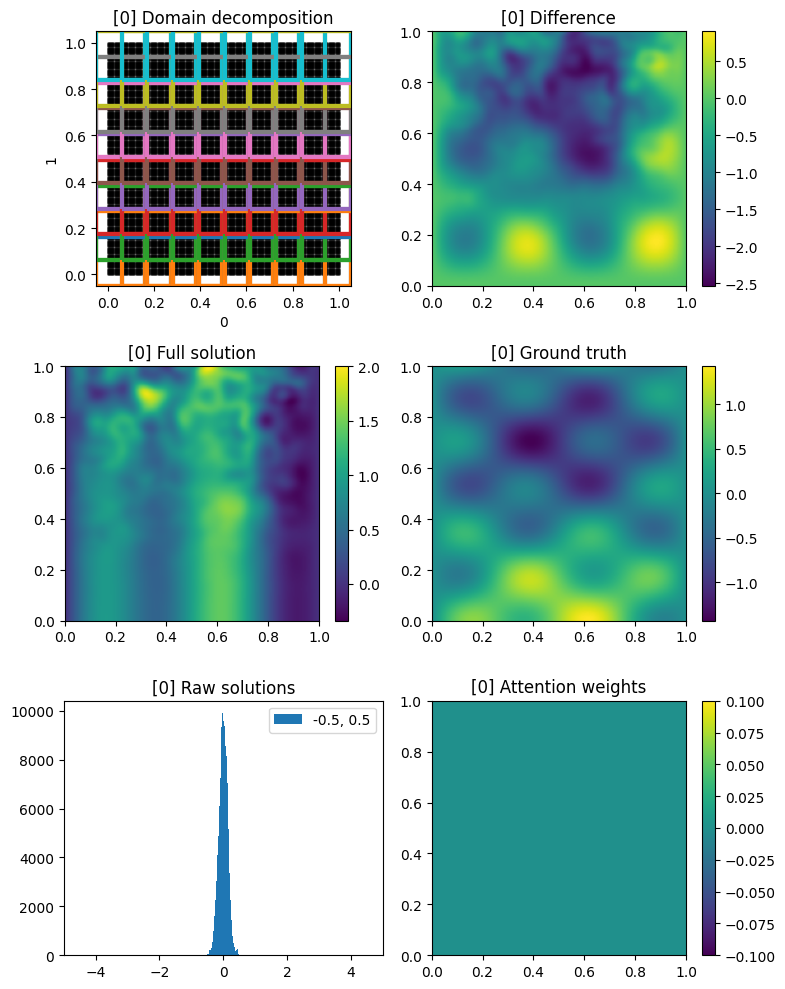

[INFO] 2025-05-13 20:52:54 - [i: 1000/40000] loss: 144.7806 rate: 37.5 elapsed: 0.01 hr test
[INFO] 2025-05-13 20:53:15 - [i: 2000/40000] loss: 16.7110 rate: 47.5 elapsed: 0.01 hr test
[INFO] 2025-05-13 20:53:37 - [i: 3000/40000] loss: 4.4951 rate: 47.4 elapsed: 0.02 hr test
[INFO] 2025-05-13 20:53:58 - [i: 4000/40000] loss: 2.9626 rate: 47.3 elapsed: 0.03 hr test
[INFO] 2025-05-13 20:54:19 - [i: 5000/40000] loss: 5.1797 rate: 47.5 elapsed: 0.03 hr test
[INFO] 2025-05-13 20:54:19 - saved arrays


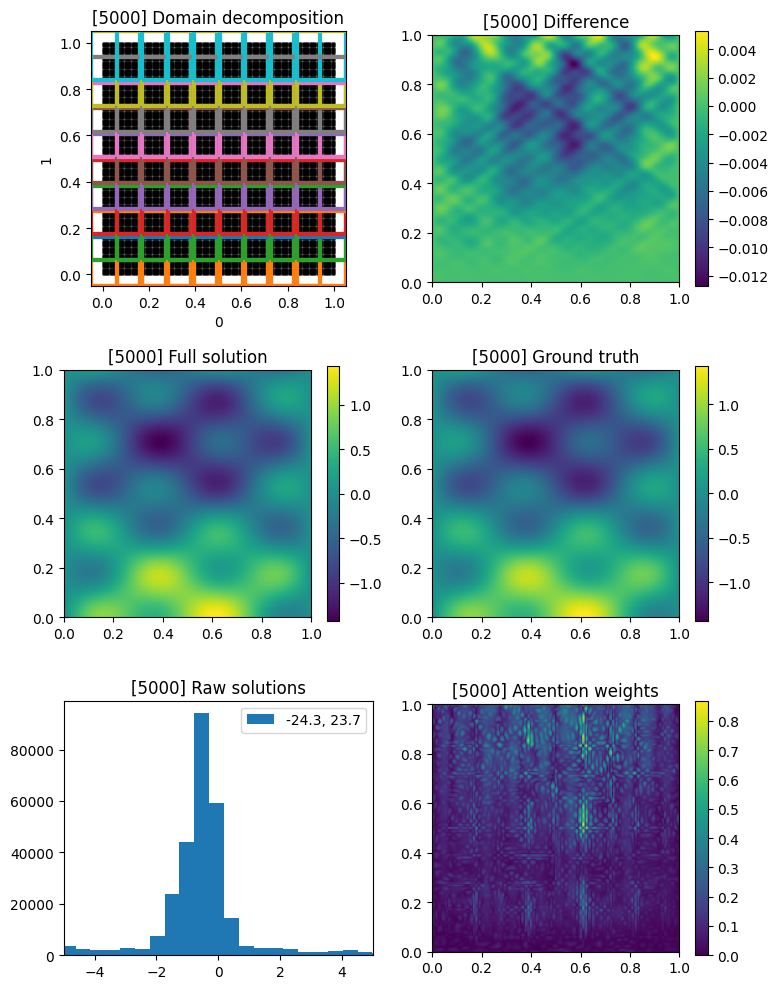

[INFO] 2025-05-13 20:54:41 - [i: 6000/40000] loss: 0.9937 rate: 47.5 elapsed: 0.04 hr test
[INFO] 2025-05-13 20:55:02 - [i: 7000/40000] loss: 1.0147 rate: 47.5 elapsed: 0.04 hr test
[INFO] 2025-05-13 20:55:23 - [i: 8000/40000] loss: 2.9844 rate: 47.5 elapsed: 0.05 hr test
[INFO] 2025-05-13 20:55:44 - [i: 9000/40000] loss: 0.9455 rate: 47.5 elapsed: 0.06 hr test
[INFO] 2025-05-13 20:56:05 - [i: 10000/40000] loss: 2.9675 rate: 47.5 elapsed: 0.06 hr test
[INFO] 2025-05-13 20:56:06 - saved arrays


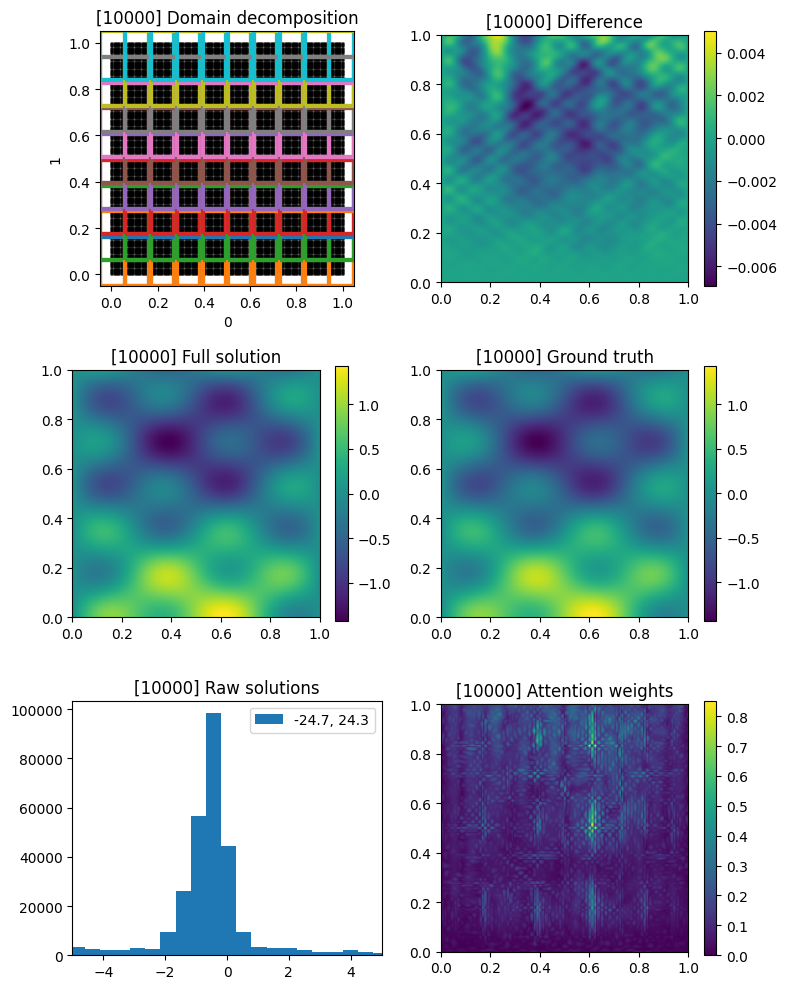

[INFO] 2025-05-13 20:56:28 - [i: 11000/40000] loss: 1.2153 rate: 47.5 elapsed: 0.07 hr test
[INFO] 2025-05-13 20:56:49 - [i: 12000/40000] loss: 0.9178 rate: 47.5 elapsed: 0.07 hr test
[INFO] 2025-05-13 20:57:10 - [i: 13000/40000] loss: 0.7117 rate: 47.5 elapsed: 0.08 hr test
[INFO] 2025-05-13 20:57:31 - [i: 14000/40000] loss: 3.9912 rate: 47.5 elapsed: 0.08 hr test
[INFO] 2025-05-13 20:57:52 - [i: 15000/40000] loss: 3.0683 rate: 47.5 elapsed: 0.09 hr test
[INFO] 2025-05-13 20:57:52 - saved arrays


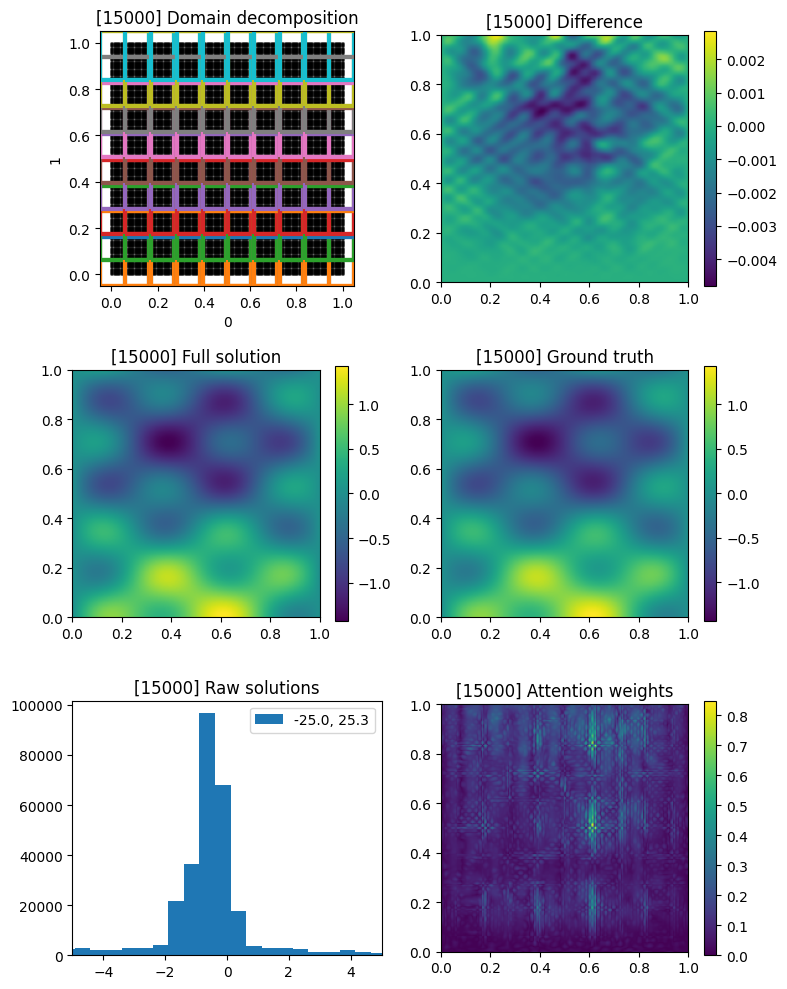

[INFO] 2025-05-13 20:58:14 - [i: 16000/40000] loss: 0.8633 rate: 47.5 elapsed: 0.10 hr test
[INFO] 2025-05-13 20:58:35 - [i: 17000/40000] loss: 0.4827 rate: 47.5 elapsed: 0.10 hr test
[INFO] 2025-05-13 20:58:56 - [i: 18000/40000] loss: 1.5537 rate: 47.5 elapsed: 0.11 hr test
[INFO] 2025-05-13 20:59:17 - [i: 19000/40000] loss: 0.6292 rate: 47.5 elapsed: 0.11 hr test
[INFO] 2025-05-13 20:59:38 - [i: 20000/40000] loss: 0.4241 rate: 47.5 elapsed: 0.12 hr test
[INFO] 2025-05-13 20:59:39 - saved arrays


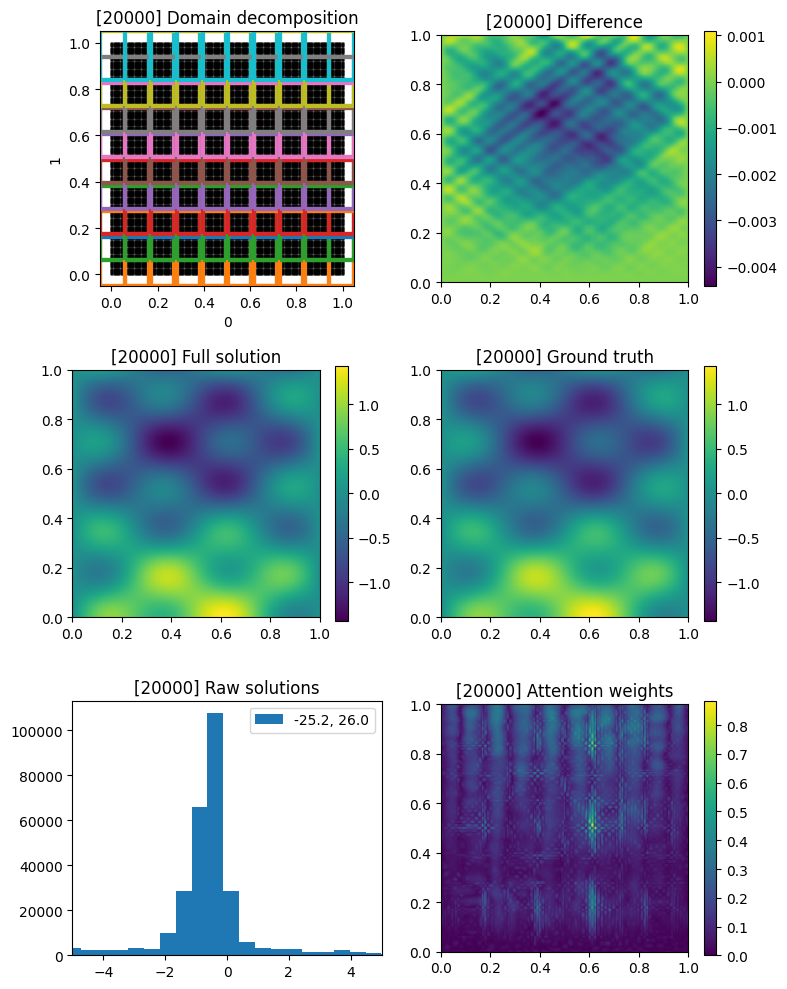

[INFO] 2025-05-13 21:00:00 - [i: 21000/40000] loss: 0.3865 rate: 47.5 elapsed: 0.13 hr test
[INFO] 2025-05-13 21:00:21 - [i: 22000/40000] loss: 0.5763 rate: 47.5 elapsed: 0.13 hr test
[INFO] 2025-05-13 21:00:43 - [i: 23000/40000] loss: 12.4740 rate: 47.5 elapsed: 0.14 hr test
[INFO] 2025-05-13 21:01:04 - [i: 24000/40000] loss: 1.7222 rate: 47.5 elapsed: 0.14 hr test
[INFO] 2025-05-13 21:01:25 - [i: 25000/40000] loss: 0.6233 rate: 47.5 elapsed: 0.15 hr test
[INFO] 2025-05-13 21:01:25 - saved arrays


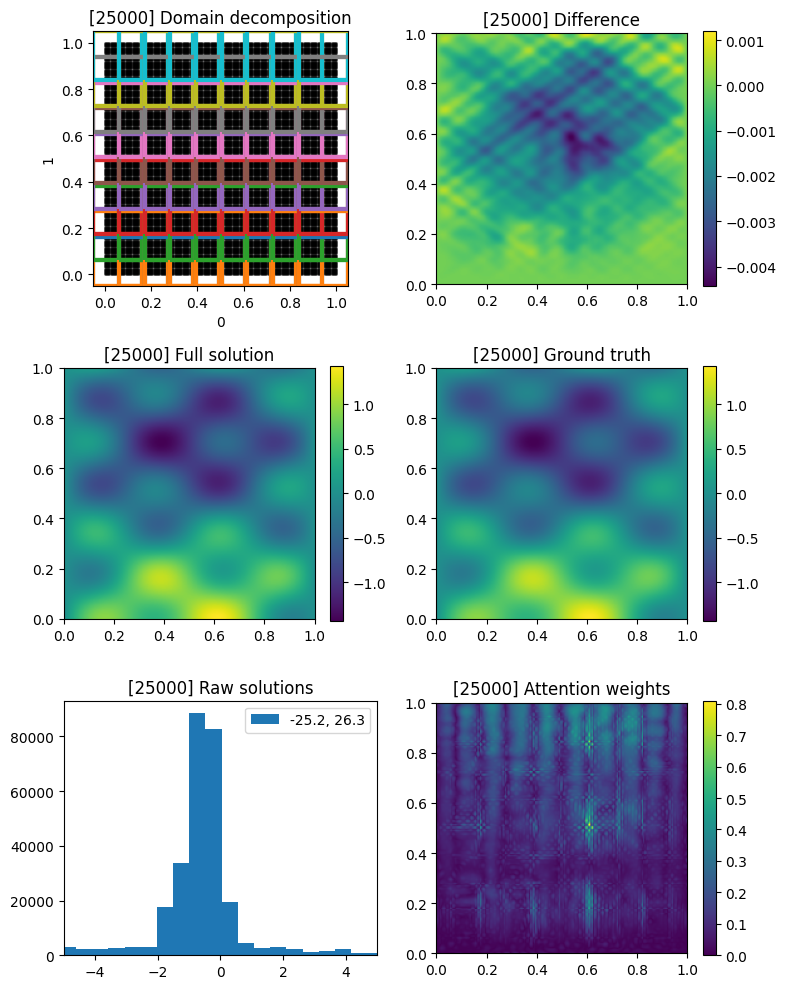

[INFO] 2025-05-13 21:01:47 - [i: 26000/40000] loss: 0.8504 rate: 47.3 elapsed: 0.16 hr test
[INFO] 2025-05-13 21:02:08 - [i: 27000/40000] loss: 0.3659 rate: 46.9 elapsed: 0.16 hr test
[INFO] 2025-05-13 21:02:29 - [i: 28000/40000] loss: 0.2619 rate: 47.5 elapsed: 0.17 hr test
[INFO] 2025-05-13 21:02:50 - [i: 29000/40000] loss: 0.2533 rate: 47.5 elapsed: 0.17 hr test
[INFO] 2025-05-13 21:03:12 - [i: 30000/40000] loss: 0.3113 rate: 47.5 elapsed: 0.18 hr test
[INFO] 2025-05-13 21:03:12 - saved arrays


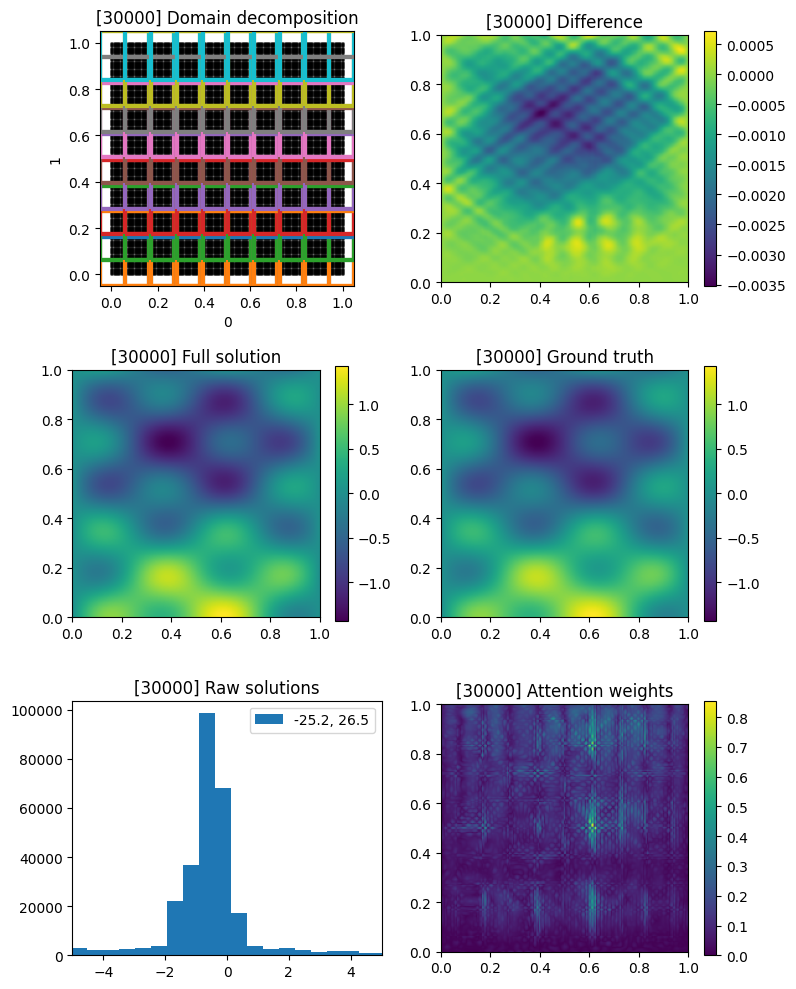

[INFO] 2025-05-13 21:03:34 - [i: 31000/40000] loss: 0.8545 rate: 47.5 elapsed: 0.19 hr test
[INFO] 2025-05-13 21:03:55 - [i: 32000/40000] loss: 0.2381 rate: 47.5 elapsed: 0.19 hr test
[INFO] 2025-05-13 21:04:16 - [i: 33000/40000] loss: 0.2308 rate: 47.5 elapsed: 0.20 hr test
[INFO] 2025-05-13 21:04:37 - [i: 34000/40000] loss: 0.2838 rate: 47.5 elapsed: 0.20 hr test
[INFO] 2025-05-13 21:04:58 - [i: 35000/40000] loss: 0.2370 rate: 47.5 elapsed: 0.21 hr test
[INFO] 2025-05-13 21:04:58 - saved arrays


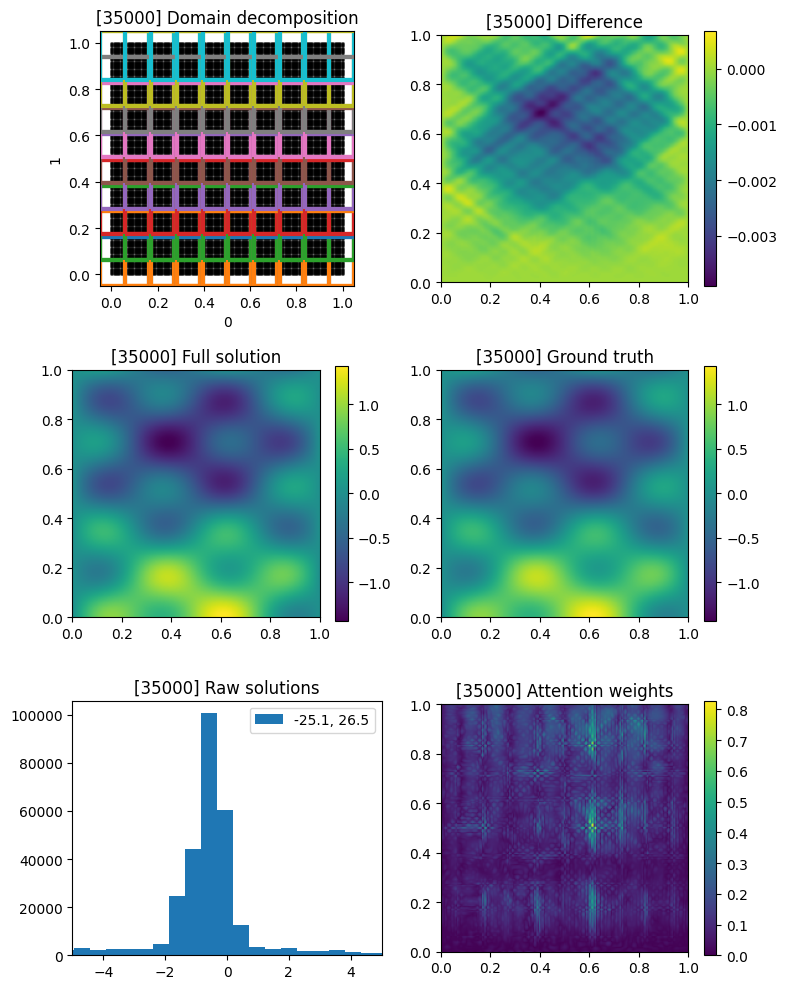

[INFO] 2025-05-13 21:05:20 - [i: 36000/40000] loss: 0.2366 rate: 47.5 elapsed: 0.22 hr test
[INFO] 2025-05-13 21:05:41 - [i: 37000/40000] loss: 0.7405 rate: 47.5 elapsed: 0.22 hr test
[INFO] 2025-05-13 21:06:02 - [i: 38000/40000] loss: 1.2618 rate: 47.5 elapsed: 0.23 hr test
[INFO] 2025-05-13 21:06:24 - [i: 39000/40000] loss: 0.6627 rate: 47.5 elapsed: 0.23 hr test
[INFO] 2025-05-13 21:06:45 - [i: 40000/40000] loss: 2.0158 rate: 47.5 elapsed: 0.24 hr test
[INFO] 2025-05-13 21:06:45 - saved arrays


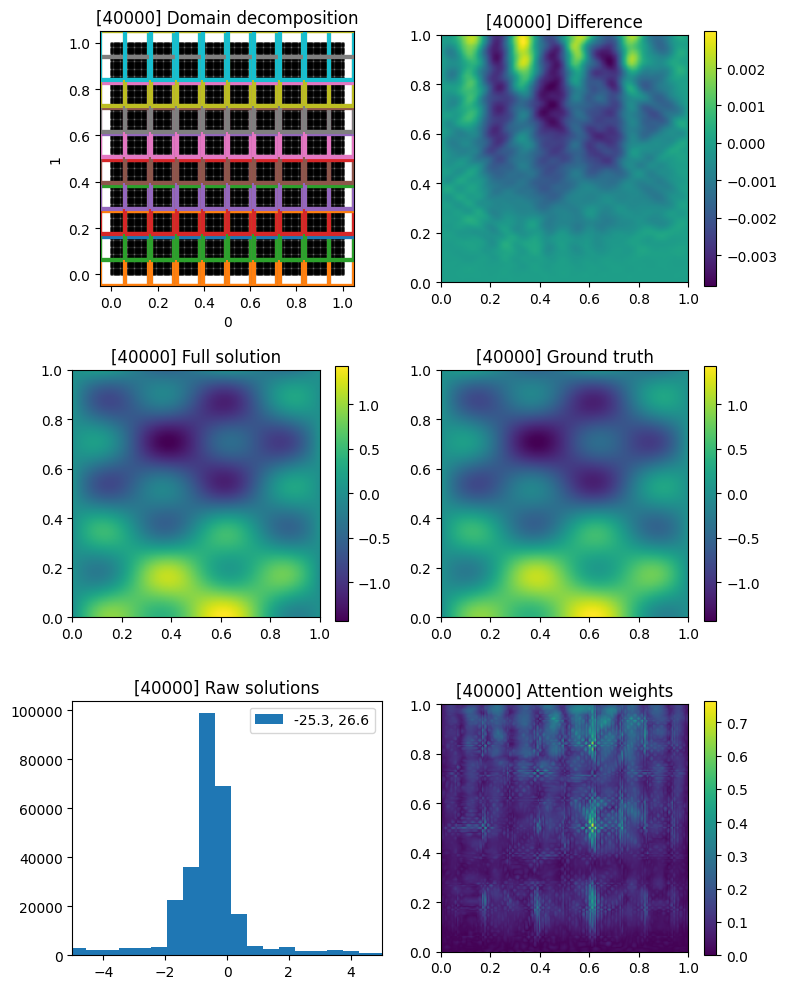

[INFO] 2025-05-13 21:06:46 - [i: 40000/40000] Training complete
[INFO] 2025-05-13 21:06:46 - [i: 40000/40000] Total training time: 859.40 s


In [ ]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, ChebyshevAdaptiveKAN, StackedChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,10), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,5.),
    ),
    network=FCN,
    network_init_kwargs = dict(
        layer_sizes = (2, 16, 16, 1),
    ),
    # network=StackedChebyshevKAN,
    # network_init_kwargs=dict(
    #     input_dim=2,
    #     hidden_dim=4,
    #     output_dim=1,
    #     degree=6
    # ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=40000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

In [ ]:
all_params

{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2),
   'c': Array(1.4142135, dtype=float32, weak_type=True),
   'sd': 0.1},
  'decomposition': {'m': 100,
   'xd': 2,
   'subdomain': {'params': [Array([[-0.16111112, -0.16111112],
            [-0.16111112, -0.05      ],
            [-0.16111112,  0.06111111],
            [-0.16111112,  0.17222223],
            [-0.16111112,  0.28333333],
            [-0.16111112,  0.39444444],
            [-0.16111112,  0.50555557],
            [-0.16111112,  0.6166667 ],
            [-0.16111112,  0.7277778 ],
            [-0.16111112,  0.8388889 ],
            [-0.05      , -0.16111112],
            [-0.05      , -0.05      ],
            [-0.05      ,  0.06111111],
            [-0.05      ,  0.17222223],
            [-0.05      ,  0.28333333],
            [-0.05      ,  0.39444444],
            [-0.05      ,  0.50555557],
            [-0.05      ,  0.61666